# Setup

## Imports

In [1]:
import numpy as np
import h5py
import mat73

## Load File Paths

In [2]:
# ncsl_share = '/run/user/1000/gvfs/smb-share:server=10.162.37.21,share=main'
# data_path = f'Data/Subject06_snapshot_normalized.npy'
subs = ['07']
file_paths = {}

for sub in subs:
    # create a dictionary holding the file paths
    ncsl_share = '/mnt/ncsl_share'
    file_paths[sub] = {
        'setup_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Setup.mat',
        'raw_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Raw.mat',
        # 'misc_path' : ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Filt.mat',
        'data_path': ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject{sub}_snapshot_normalized.npy', # movement onset as event
        # 'data_path' : ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/show-card_pre-2sec_post-4sec/Subject{sub}_snapshot_normalized.npy', # visual cue as event
        'out_path_metrics': f'Metrics/Subject{sub}_movement',
        'out_path_plots': f'Plots/Subject{sub}_movement'
    }

In [3]:
raw_file = h5py.File(file_paths['07']['raw_path'])
setup_data = mat73.loadmat(file_paths['07']['setup_path'])
# raw_data = mat73.loadmat(file_paths['07']['raw_path'])

out_path_plots = file_paths['07']['out_path_plots']
out_path_metrics = file_paths['07']['out_path_metrics']

## Instantiate Variables

In [4]:
bets = setup_data['filters']['bets']

good_trials = np.where(np.isnan(bets) == False)[0] # extract indices of trials without the 'nan'

bets = bets[good_trials] # get the bet values for the good trials
subject_cards = setup_data['filters']['card1'][good_trials] # get the subject's card values for the good trials

In [5]:
elec_names = np.array(setup_data['elec_name'])
elec_areas = np.array(setup_data['elec_area'])

In [6]:
data = np.load(file_paths['07']['data_path'])[:,:,:,:60] # 0:60 = -3:0 seconds
y = np.asarray([(0 if bet == 5 else 1) for bet in bets]) # 0 = low bet ($5), 1 = high bet ($20)

In [7]:
wavelet_freqs = np.logspace(np.log2(2),np.log2(150),num=63,base=2)

frequency_band_indices ={
    "Delta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 0.5 and freq < 4],
    "Theta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 4 and freq < 8],
    "Alpha" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 8 and freq < 14],
    "Beta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 14 and freq < 30],
    "Gamma" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 30]
}

f_band_data = np.zeros((data.shape[0], data.shape[1], 5, data.shape[3]))

for i, key in enumerate(frequency_band_indices):
    f_band_data[:,:,i,:] = data[:,:,frequency_band_indices[key],:].mean(2)

# Simulate Data

In [9]:
simulated_data = np.random.normal(size=f_band_data.shape)
high_bet_idxs = np.where(y == 1)[0].reshape((-1,1))
low_bet_idxs = np.where(y == 0)[0].reshape((-1,1))

In [10]:
simulated_data[high_bet_idxs,:,:3,-20:] = 1
# simulated_data[high_bet_idxs,:,3:,:20] = 1
# simulated_data[low_bet_idxs,:,:3,:20] = -1
simulated_data[low_bet_idxs,:,3:,-20:] = 0.5

In [11]:
from LDA import TrainOptimalTimeWindows

clf = TrainOptimalTimeWindows(data=simulated_data, setup_data=setup_data)

In [12]:
filtered_num_channels = clf.filter_channels()[2]

In [13]:
clf.train_on_optimal_time_windows(simulated_data, y, n_processes=20, n_channels=filtered_num_channels)

Channel 103 done
Channel 97 done
Channel 89 done
Channel 76 done
Channel 124 done
Channel 92 done
Channel 12 done
Channel 49 done
Channel 43 done
Channel 19 done
Channel 86 done
Channel 37 done
Channel 128 done
Channel 53 done
Channel 61 done
Channel 67 done
Channel 68 done
Channel 63 done
Channel 111 done
Channel 51 done
Channel 126 done
Channel 2 done
Channel 105 done
Channel 93 done
Channel 54 done
Channel 21 done
Channel 38 done
Channel 75 done
Channel 45 done
Channel 7 done
Channel 102 done
Channel 52 done
Channel 88 done
Channel 9 done
Channel 112 done
Channel 122 done
Channel 78 done
Channel 17 done
Channel 109 done
Channel 62 done
Channel 33 done
Channel 123 done
Channel 58 done
Channel 32 done
Channel 59 done
Channel 3 done
Channel 99 done
Channel 44 done
Channel 22 done
Channel 94 done
Channel 104 done
Channel 35 done
Channel 36 done
Channel 77 done
Channel 28 done
Channel 119 done
Channel 16 done
Channel 42 done
Channel 8 done
Channel 18 done
Channel 14 done
Channel 69 done


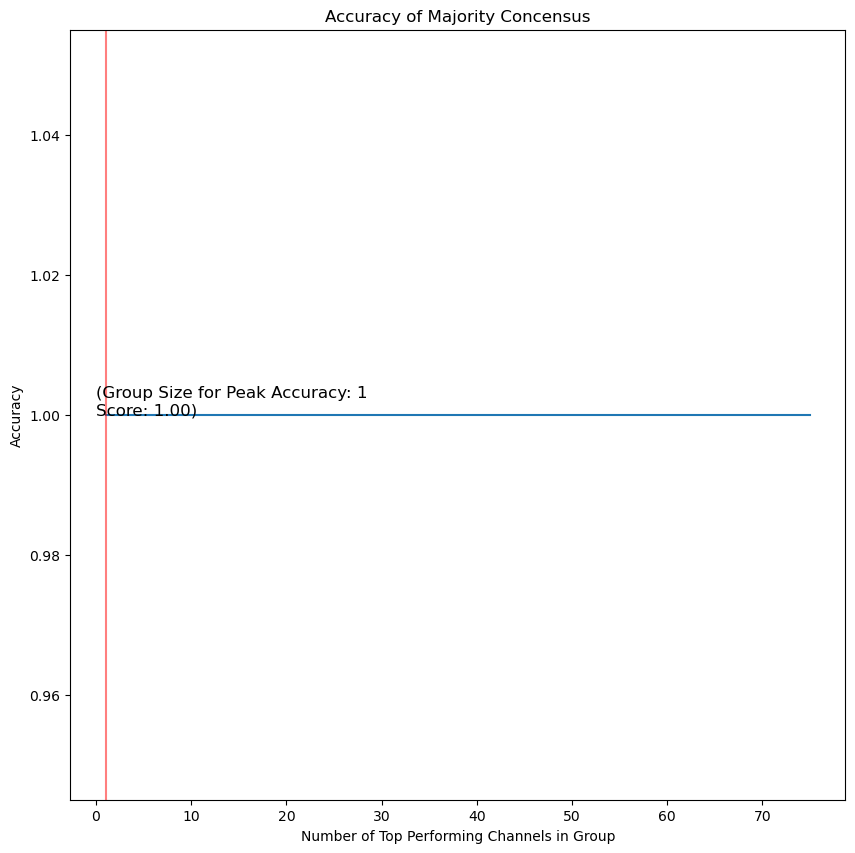

In [14]:
clf.plot_accuracies(y)

In [15]:
results = clf.get_optimal_channel_combination(y, max_channels=10)

[2]


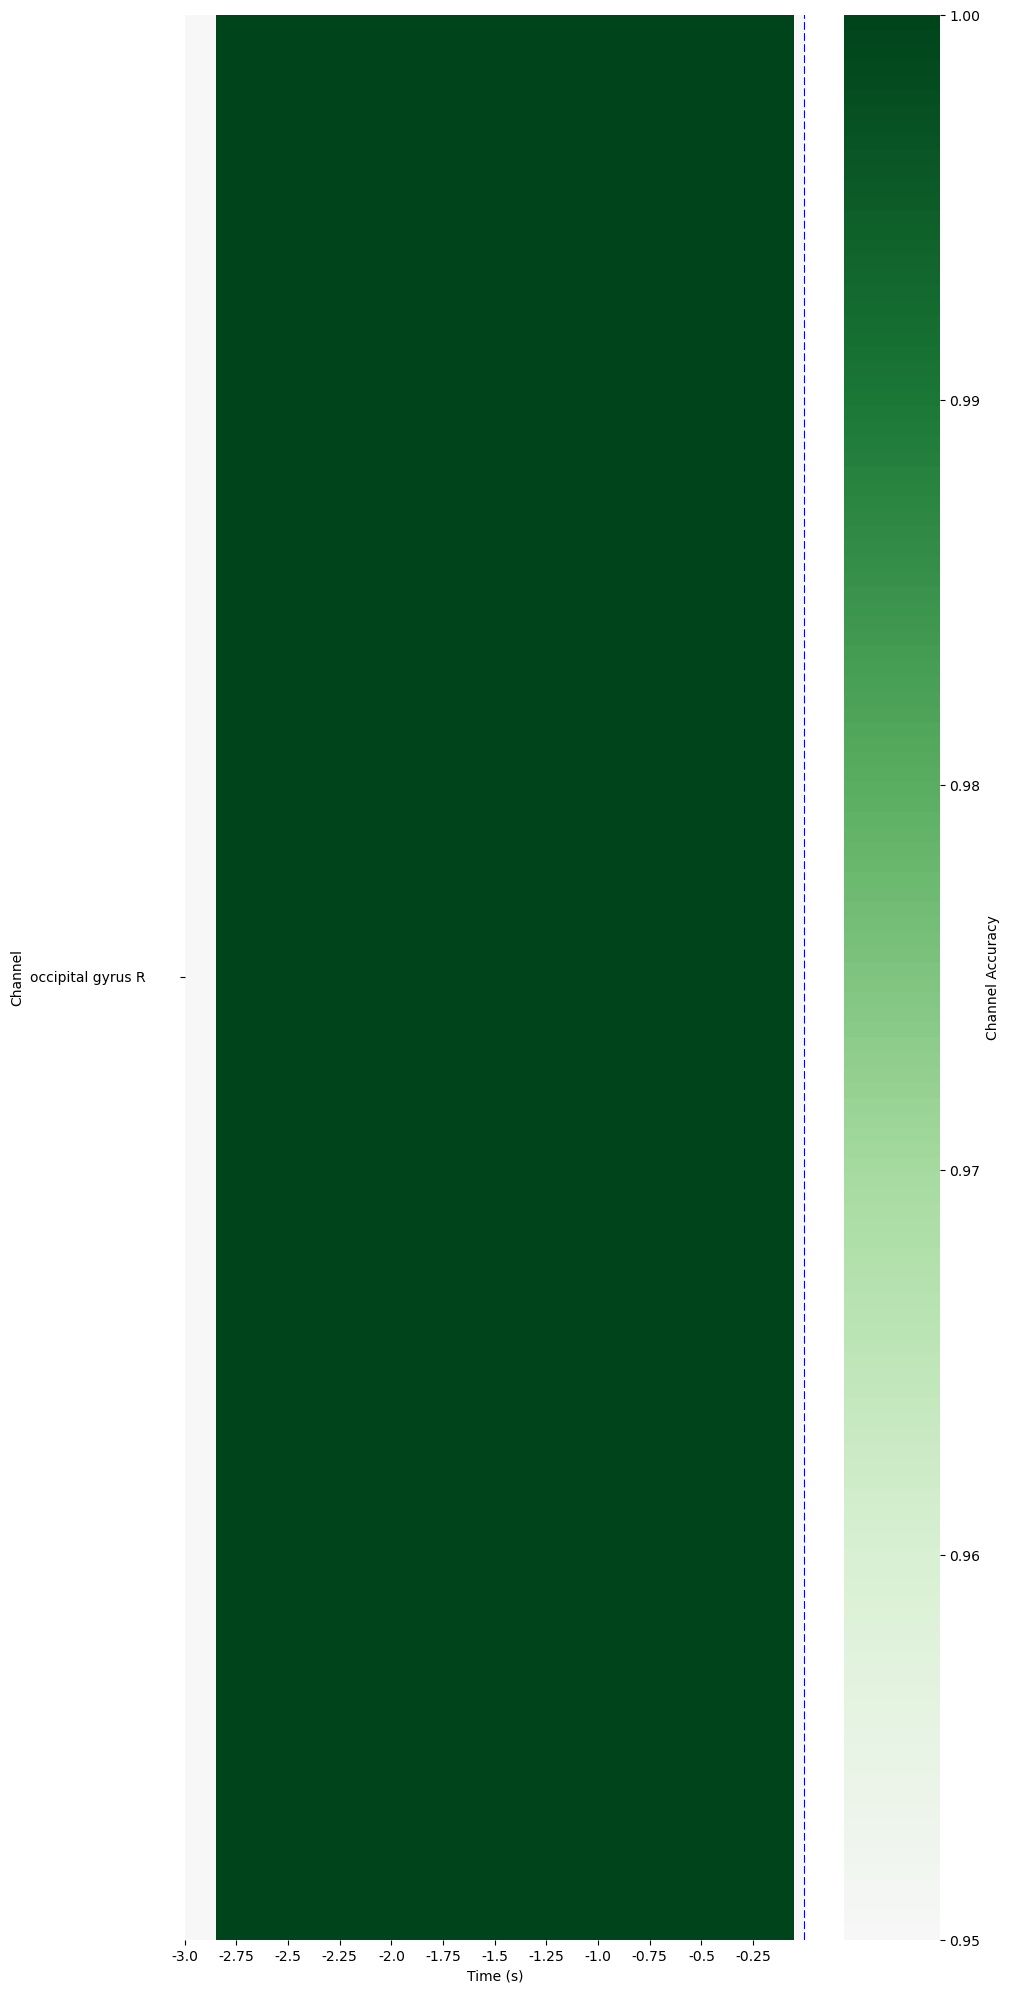

In [16]:
clf.plot_heatmap(results[0][0], event_delay=3, top_accuracy=results[0][1], optimal_combination=True)

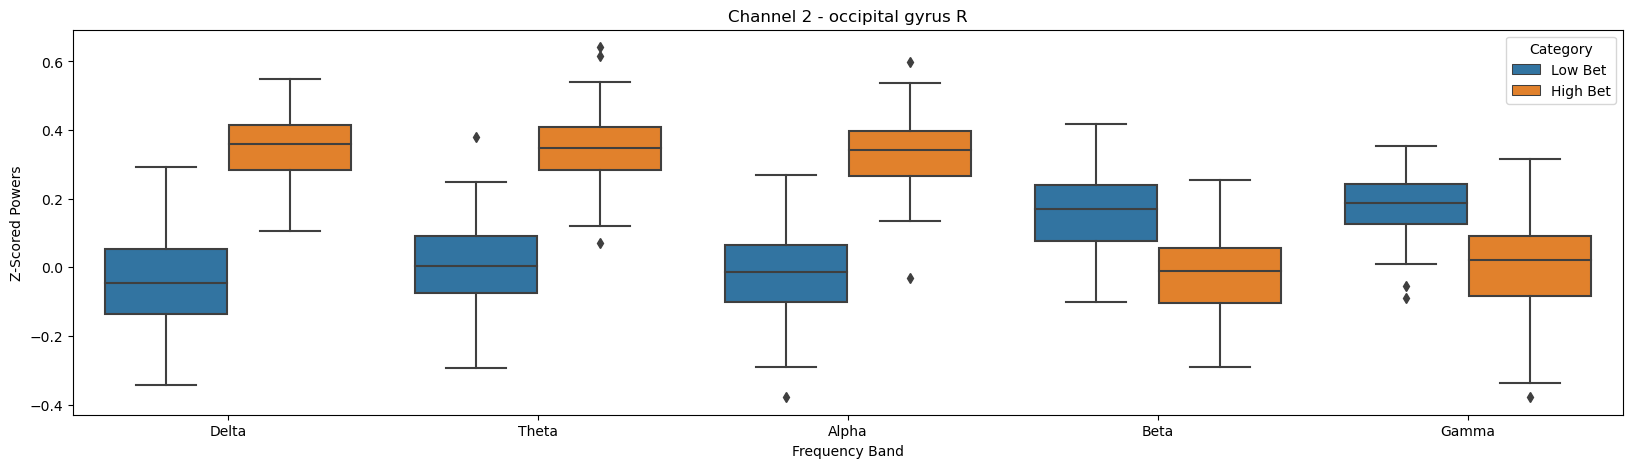

In [17]:
clf.plot_freq_box_plots(y, results[0][0])